In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import numpy as np
warnings.filterwarnings("ignore")



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


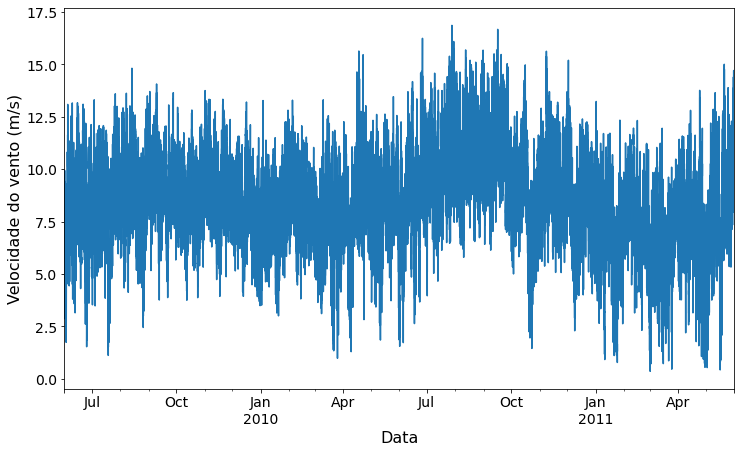

In [4]:
# OPEN WIND SPEED TIME SERIES
series_ws = pd.read_excel('wind_speed_main_db.xlsx', header=0, index_col=0, parse_dates=True, squeeze=True)


# Plot 2009-2010 and 2010-2011 wind speed time series
fig = plt.figure()
series_ws.plot(figsize=(12, 7))

plt.xlabel("Data", fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel("Velocidade do vento (m/s)", fontsize=16)
plt.yticks(fontsize=14)
plt.show()

fig.savefig('velocidade_do_vento.eps', format='eps', dpi=1200)

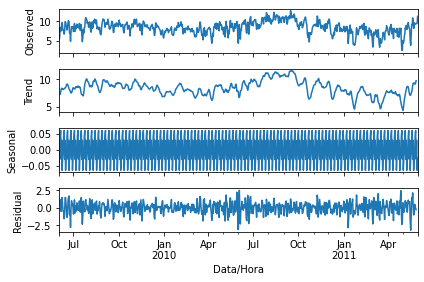

In [ ]:
series_ws = series_ws.resample('D').mean()
result = seasonal_decompose(series_ws, model='additive')
result.plot().savefig('seasonal_decompose.eps',format='eps', dpi=1000)
# plt.show()

In [ ]:
# Calculate stationarity test of time series data
from statsmodels.tsa.stattools import adfuller
y = series_ws.resample('D').mean()

X = y
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.730673
p-value: 0.068879
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


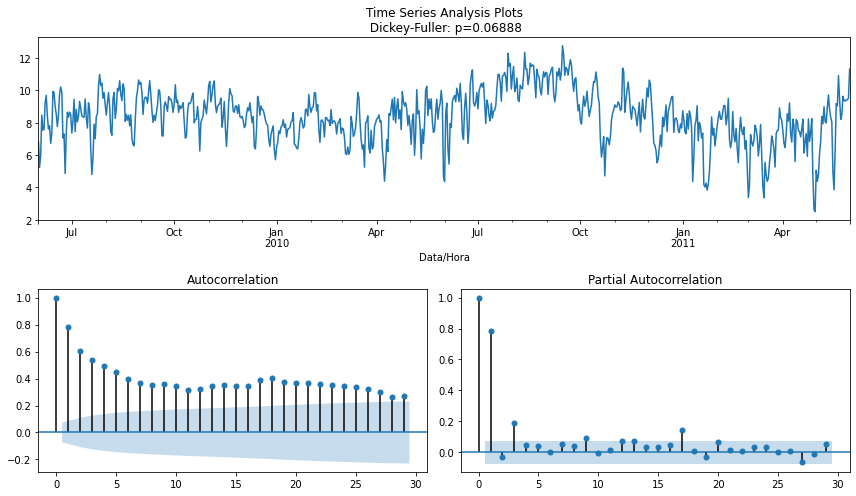

In [5]:
# RESAMPLE DATA TO DAYS INSTEAD OF 10 MIN
series_ws = series_ws.resample('D').mean()

# INTERPOLATE DATA THAT HAVE NaN
series_ws = series_ws.interpolate()

# SCRIPT from https://towardsdatascience.com/multi-step-time-series-forecasting-with-arima-lightgbm-and-prophet-cc9e3f95dfb0
def tsplot(y, lags=None, figsize=(12, 7)):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    
    fig.savefig('ACF_PACF_ADF.eps', format='eps', dpi=1200)

tsplot(series_ws)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


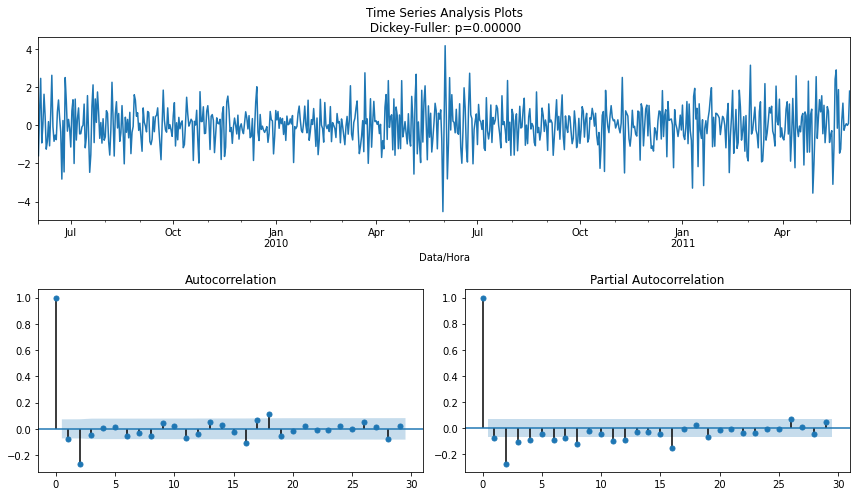

In [6]:
# 1º DIFERENCIAÇÃO
series_ws_diff = (series_ws - series_ws.shift(1)).dropna()
tsplot(series_ws_diff)

In [ ]:
result = adfuller(series_ws_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.481320
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [7]:
# DIVIDINDO A SÉRIE TEMPORAL EM 80% TREINAMENTO E 20% TESTE
test_len = int(len(series_ws) * 0.2)
series_ws_train, series_ws_test = series_ws.iloc[:-test_len], series_ws.iloc[-test_len:]

In [8]:
!pip install sktime

     |████████████████████████████████| 6.6 MB 3.8 MB/s 
     |████████████████████████████████| 9.8 MB 31.2 MB/s 
     |████████████████████████████████| 3.3 MB 28.8 MB/s 
     |████████████████████████████████| 34.5 MB 1.3 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [9]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 


In [30]:
#!pip install sktime

from sktime.forecasting.arima import AutoARIMA
import pmdarima as pm

forecaster = AutoARIMA(suppress_warnings=True)
forecaster.fit(series_ws_train)
forecaster.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(1, 1, 3)   Log Likelihood                -767.134
Date:                Tue, 26 Apr 2022   AIC                           1544.269
Time:                        19:40:10   BIC                           1566.110
Sample:                             0   HQIC                          1552.782
                                - 584                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6789      0.117      5.779      0.000       0.449       0.909
ma.L1         -0.9007      0.129     -6.970      0.000      -1.154      -0.647
ma.L2         -0.2173      0.059     -3.681      0.000      -0.333      -0.102
ma.L3          0.1632      0.077      2.108      0.035       0.011       0.315
sigma2         0.8122      0.040     20.416      0.000       0.734       0.890
===================================================================================
Ljung-Box (Q):                       43.28   Jarque-Bera (JB):                28.99
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.29
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


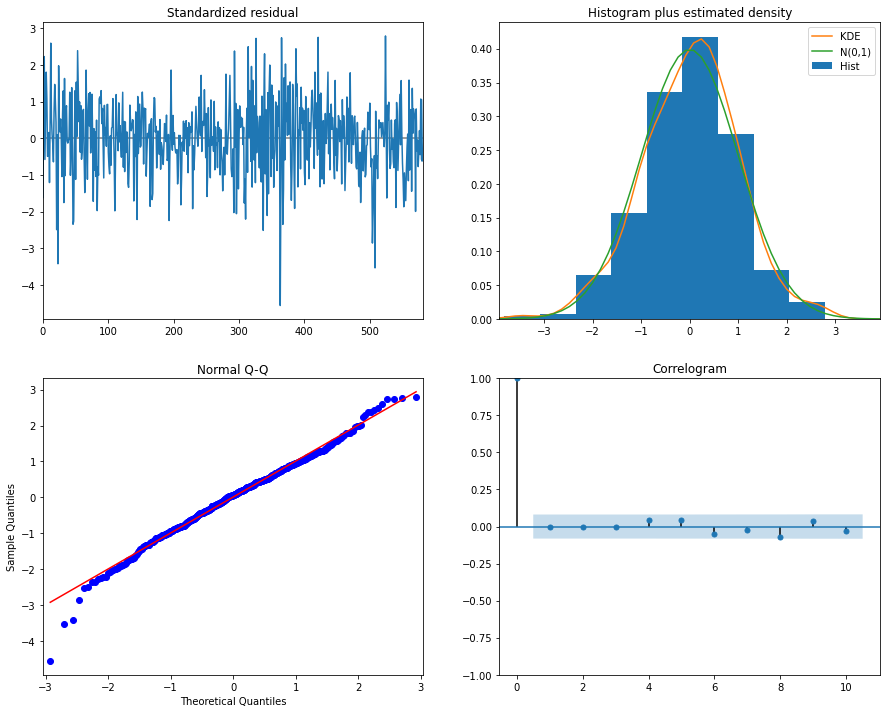

In [32]:
#!pip install pmdarima
# pmdarima
forecaster2 = pm.auto_arima(series_ws_train,suppress_warnings=True)

forecaster2.plot_diagnostics(figsize=(15, 12))
plt.savefig('diagnostico_arima.eps', format='eps', dpi=1200)
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


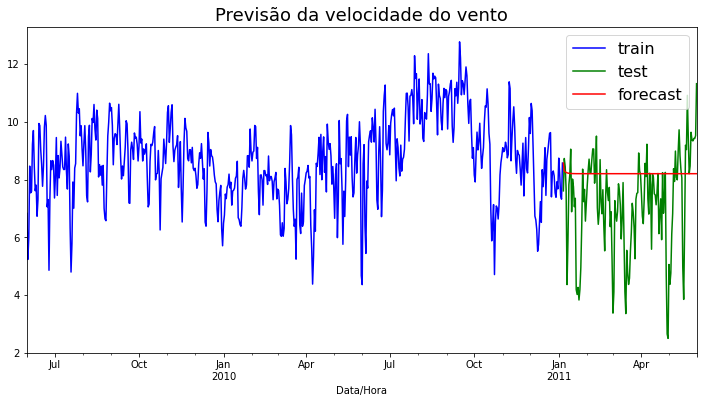

In [33]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    #plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    plt.title(f"Previsão da velocidade do vento", size=18)

    # series_train.index = pd.to_datetime(series_train.index) # TRANSFORMANDO O ÍNDICE EM DATA-HORA
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.savefig('prev_vel_vento.eps', format='eps', dpi=1200)
    plt.show()
    

    return mae, mape

fh = np.arange(test_len) + 1
forecast = forecaster.predict(fh)

sun_arima_mae, sun_arima_mape = plot_forecast(series_ws_train, series_ws_test, forecast)

In [ ]:
# STATISTICAL METRICS TO ASSESS THE FORECAST MODEL

# MAE
def mean_absolute_error(true, pred):
    abs_error = np.abs(true - pred)
    sum_abs_error = np.sum(abs_error)
    mae_loss = sum_abs_error / true.size
    return mae_loss

#MAPE
def mean_absolute_percentage_error(true, pred):
    abs_error = (np.abs(true - pred)) / true
    sum_abs_error = np.sum(abs_error)
    mape_loss = (sum_abs_error / true.size) * 100
    return mape_loss

#MSE
def mean_squared_error(true, pred):
    squared_error = np.square(true - pred) 
    sum_squared_error = np.sum(squared_error)
    mse_loss = sum_squared_error / true.size
    return mse_loss

#RMSE
def root_mean_squared_error(true, pred):
    squared_error = np.square(true - pred) 
    sum_squared_error = np.sum(squared_error)
    rmse_loss = np.sqrt(sum_squared_error / true.size)
    return rmse_loss

#RRMSE
def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss


In [ ]:
print("MAE: ", mean_absolute_error(series_ws_test,forecast))
print("MAPE: ", mean_absolute_percentage_error(series_ws_test,forecast))
print("MSE: ", mean_squared_error(series_ws_test,forecast))
print("RMSE: ", root_mean_squared_error(series_ws_test,forecast))
print("RRMSE: ", relative_root_mean_squared_error(series_ws_test,forecast))

MAE:  1.4574018039761478
MAPE:  0.2774520122326351
MSE:  3.872626767843166
RMSE:  1.9678990746080363
RRMSE:  0.23971123004680872
